# EFC 1 - Regressão linear para a predição de manchas solares
    Utilizando os dados fornecidos sobre manchas solares de 1749 até 2019

In [13]:
import pandas as pd
import math
import numpy as np
from numpy import genfromtxt
from numpy import linalg
import matplotlib.pyplot as plt 
from scipy.linalg import toeplitz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

In [14]:
manchas = genfromtxt('monthly-sunspots.csv', delimiter=',')

In [15]:
manchas = np.delete(manchas,np.s_[0:2],axis=1)
manchas = np.delete(manchas,0,axis=0)

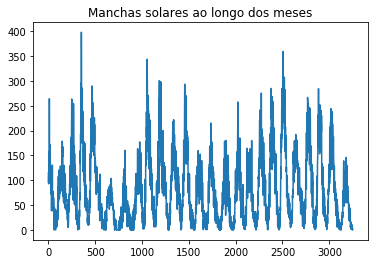

In [16]:
plt.plot(manchas)
plt.title("Manchas solares ao longo dos meses")
plt.show()

In [17]:
K = 24
X = toeplitz(manchas[::-1]) # matriz de entrada
y = manchas[K:] # vetor de saída
N = len(y)
print(X)
print(y)

[[  1.6   0.5   0.4 ... 116.7 104.3  96.7]
 [  0.5   1.6   0.5 ...  92.8 116.7 104.3]
 [  0.4   0.5   1.6 ... 141.7  92.8 116.7]
 ...
 [116.7  92.8 141.7 ...   1.6   0.5   0.4]
 [104.3 116.7  92.8 ...   0.5   1.6   0.5]
 [ 96.7 104.3 116.7 ...   0.4   0.5   1.6]]
[[116.7]
 [ 72.5]
 [ 75.5]
 ...
 [  0.4]
 [  0.5]
 [  1.6]]


In [18]:
XL = X[:,:K]
XL = XL[::-1]
XL = XL[:-K]
XL

array([[ 96.7, 104.3, 116.7, ..., 109.5, 105.5, 125.7],
       [104.3, 116.7,  92.8, ..., 105.5, 125.7, 116.7],
       [116.7,  92.8, 141.7, ..., 125.7, 116.7,  72.5],
       ...,
       [ 13.2,   5.7,   8.2, ...,   0.9,   0.5,   1.1],
       [  5.7,   8.2,   6.8, ...,   0.5,   1.1,   0.4],
       [  8.2,   6.8,  10.7, ...,   1.1,   0.4,   0.5]])

In [19]:
Xtest = XL[-120:,:]
ytest = y[-120:,:]
Xtrain = XL[:-120,:]
ytrain = y[:-120,:]

In [20]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

# Parte I

In [21]:
# Regressão linear sem a implementação de K-Fold
reg = LinearRegression(fit_intercept=True).fit(Xtreino, ytreino)
est = reg.predict(Xtreino)
err = rmse(est,ytreino)
print("Root Mean Square Error:",err)
plt.plot(reg.predict(Xtreino))

NameError: name 'Xtreino' is not defined

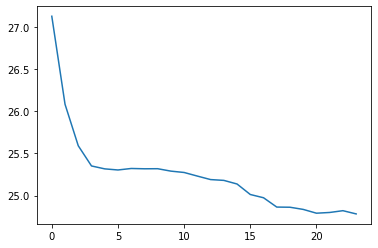

In [22]:
n_splits_kfold = 4
kf = KFold(n_splits = n_splits_kfold)

rmse_vec = np.zeros(K)
for j in range(K,0,-1):
    Xtrain_subset = Xtrain[:,j-1:]
    
    rmse_acc = 0 

    for train_index, test_index in kf.split(Xtrain_subset):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_kfold, X_test_kfold = Xtrain_subset[train_index], Xtrain_subset[test_index]
        y_train_kfold, y_test_kfold = ytrain[train_index], ytrain[test_index]
        
        reg = LinearRegression(fit_intercept=True).fit(X_train_kfold, y_train_kfold)
        ypred_kfold = reg.predict(X_test_kfold)
        rmse_acc += rmse(y_test_kfold, ypred_kfold)
    
    rmse_vec[K-j] = rmse_acc/n_splits_kfold
    #print(rmse_acc, rmse_vec[K-k])

plt.plot(rmse_vec)

best_k = rmse_vec.argmin() + 1

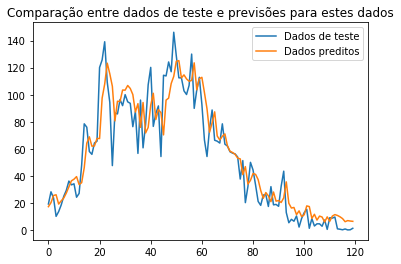

In [23]:
Xtrain_final = Xtrain[:,-best_k:]
Xtest_final = Xtest[:,-best_k:]
reg_final = LinearRegression(fit_intercept=True).fit(Xtrain_final, ytrain)
ypred_test = reg_final.predict(Xtest_final)
rmse_final = rmse(ytest, ypred_test)
rmse_final
plt.plot(ytest,label = 'Dados de teste')
plt.plot(ypred_test,label = 'Dados preditos')
plt.title("Comparação entre dados de teste e previsões para estes dados")
plt.legend()

# Parte II

In [24]:
# inicialização das variáveis
K2 = 8
Xtrain2 = Xtrain[:,-K2:]
Xtest2 = Xtest[:,-K2:]

print(Xtrain2.shape)
print(Xtest2.shape)

(3108, 8)
(120, 8)


In [25]:
# normalização dos dados
mean_norm = Xtrain2.mean()
std_norm = Xtrain2.std()
nstd = 4

Xtrain2_norm = (Xtrain2 - mean_norm)/(nstd*std_norm)
Xtest2_norm = (Xtest2 - mean_norm)/(nstd*std_norm)
ytrain2_norm = (ytrain - mean_norm)/(nstd*std_norm)
ytest2_norm = (ytest - mean_norm)/(nstd*std_norm)

(array([1056.,  693.,  527.,  355.,  250.,  139.,   64.,   19.,    3.,
           2.]),
 array([-0.30276605, -0.1573585 , -0.01195096,  0.13345659,  0.27886413,
         0.42427168,  0.56967922,  0.71508677,  0.86049431,  1.00590186,
         1.1513094 ]),
 <a list of 10 Patch objects>)

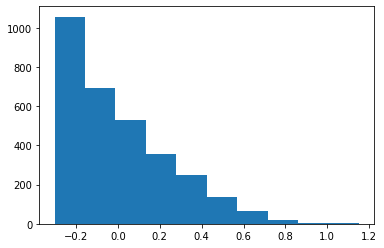

In [26]:
plt.hist(Xtrain2_norm[:,0])

In [27]:
n_splits_kfold2 = 4
kf2 = KFold(n_splits = n_splits_kfold2)
lambvec = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
Tvec = np.linspace(1,100,100)
result = np.zeros([len(Tvec),len(lambvec)])

for t in range(len(Tvec)):

    for lambridge in range(len(lambvec)):
        w = np.random.rand(K2,t+1)
        wXtrainL = np.tanh((w.T@Xtrain2_norm.T).T)

        rmseT = 0
        
        for train_index, test_index in kf2.split(Xtrain2_norm):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kfold2, X_test_kfold2 = wXtrainL[train_index], wXtrainL[test_index]
            y_train_kfold2, y_test_kfold2 = ytrain2_norm[train_index], ytrain2_norm[test_index]
            
            reg2 = Ridge(alpha = lambvec[lambridge],fit_intercept=True).fit(X_train_kfold2, y_train_kfold2)
            y_pred_kfold2 = reg2.predict(X_test_kfold2)

            y_test_kfold2 = y_test_kfold2*nstd*std_norm + mean_norm
            y_pred_kfold2 = y_pred_kfold2*nstd*std_norm + mean_norm

            rmseT += rmse(y_test_kfold2, y_pred_kfold2)
        result[t,lambridge] = rmseT/n_splits_kfold2
        #print(lambvec[lambridge],t,result[t,lambridge])
        

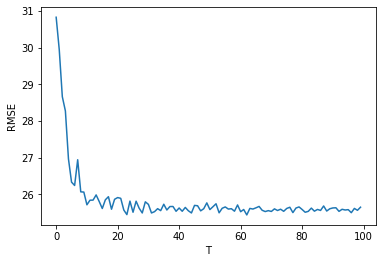

In [28]:
# gráfico RMSE x T
rmse_min = []
for i in range(len(Tvec)):
    rmse_min.append(min(result[i]))

plt.plot(range(len(rmse_min)),rmse_min)
plt.xlabel("T")
plt.ylabel("RMSE")
plt.show()

In [51]:
# cálculo index_min
amin = np.where(result == np.amin(result))
index_min = list(zip(amin[0],amin[1]))

In [52]:
# valor de T e lambda
T = (index_min[0][0]) + 1
lamb = lambvec[index_min[0][1]]

print('Mínimo valor de RMSE:',min(rmse_min))
print('Valor de T estimado:',T)
print('Valor de lambda estimado:',lamb)

Mínimo valor de RMSE: 25.44245054874256
Valor de T estimado: 63
Valor de lambda estimado: 0.1


In [ ]:
# aplicação do modelo com os valores ótimos de T e lambda

for t in range(len(Tvec)):

    for lambridge in range(len(lambvec)):
        
        
        
        w = np.random.rand(K2,T)
        wXtrainL = np.tanh((w.T@Xtrain2_norm.T).T)

        rmseT = 0
        
        for train_index, test_index in kf2.split(Xtrain2_norm):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kfold2, X_test_kfold2 = wXtrainL[train_index], wXtrainL[test_index]
            y_train_kfold2, y_test_kfold2 = ytrain2_norm[train_index], ytrain2_norm[test_index]
            
            reg2 = Ridge(alpha = lamb,fit_intercept=True).fit(X_train_kfold2, y_train_kfold2)
            y_pred_kfold2 = reg2.predict(X_test_kfold2)

            y_test_kfold2 = y_test_kfold2*nstd*std_norm + mean_norm
            y_pred_kfold2 = y_pred_kfold2*nstd*std_norm + mean_norm

        
        
reg2 = Ridge(alpha = lamb,fit_intercept=True).fit(X_train_kfold2, y_train_kfold2)
y_pred_kfold2 = reg2.predict(X_test_kfold2
print(rmse(y_test_kfold2, y_pred_kfold2))